<h3>Imports</h3>

In [2]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

from keras.applications.densenet import DenseNet121
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

2024-04-04 19:15:58.049479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 19:15:58.195213: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 19:15:58.196671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 19:15:59.023594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
os.listdir("chest_xray/chest_xray/")

['test', 'val', 'train', '.DS_Store']

In [4]:
train_dir = 'chest_xray/chest_xray/train/'
test_dir = 'chest_xray/chest_xray/test/'
val_dir = 'chest_xray/chest_xray/val/'

Train set:
PNEUMONIA=3876
NORMAL=1342
Test set:
PNEUMONIA = 390
NORMAL = 234
Validation set:
PNEUMONIA = 9
NORMAL = 9


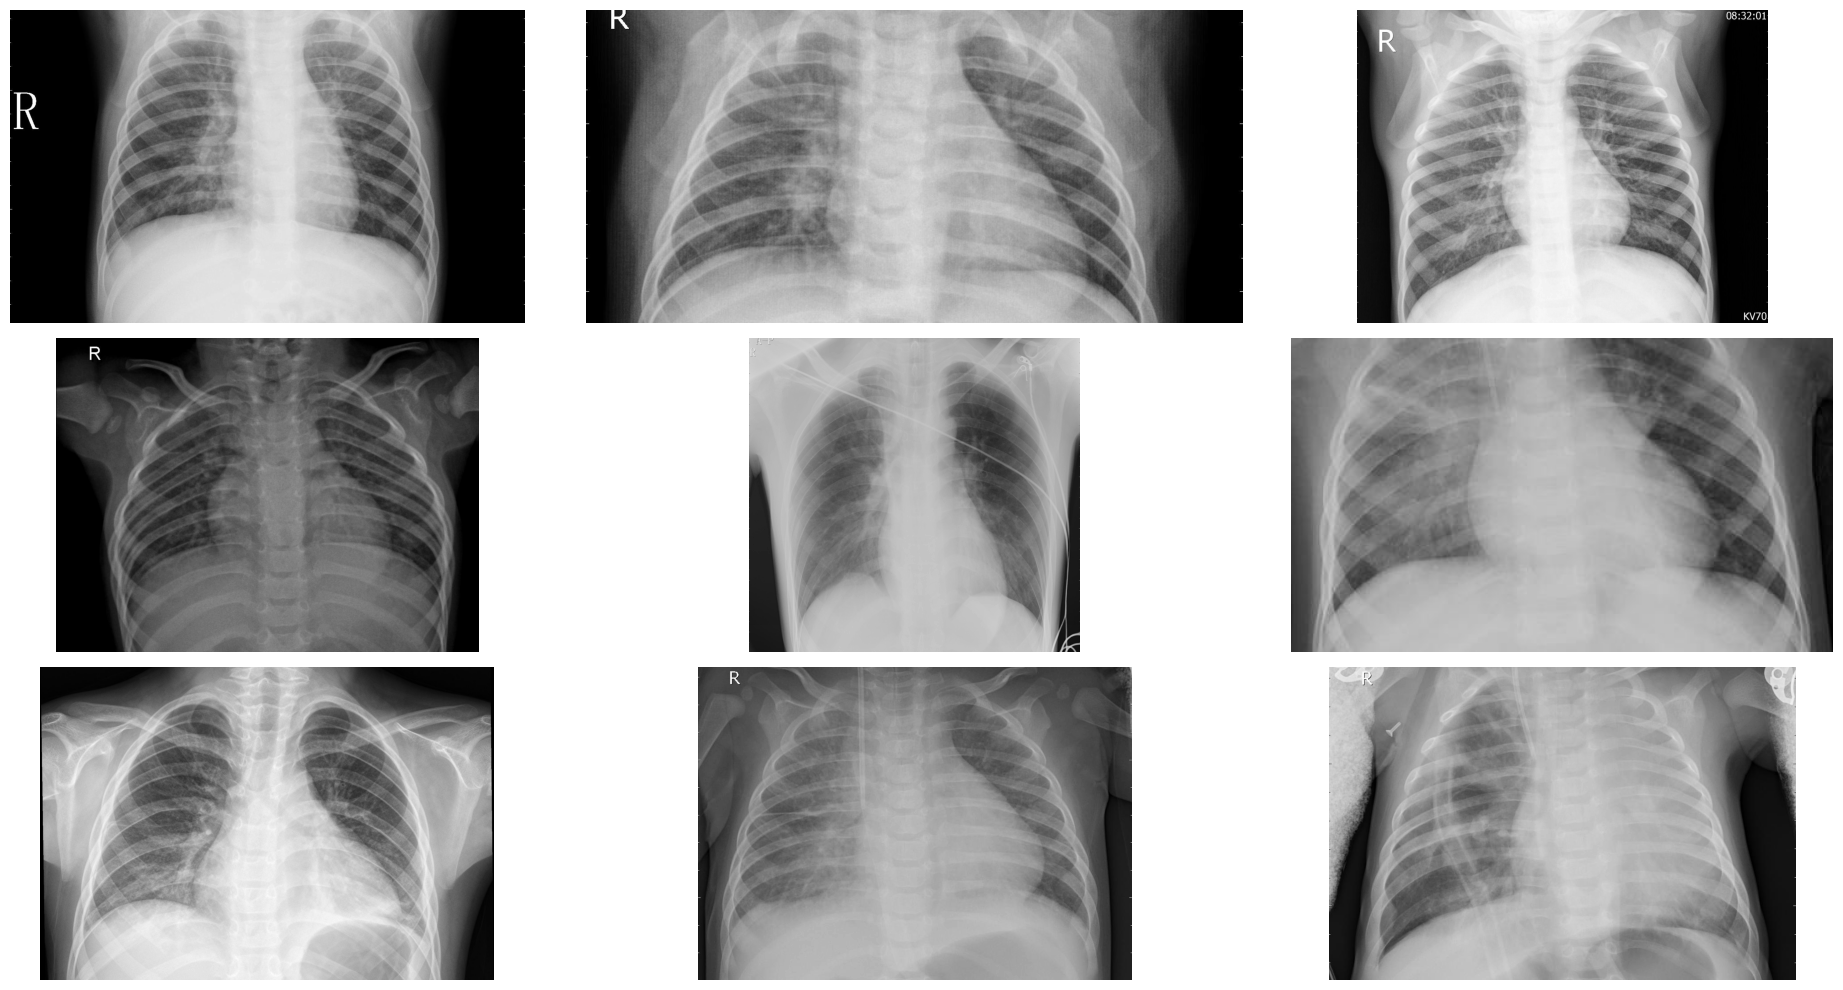

In [5]:
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("chest_xray/chest_xray/train/PNEUMONIA/")
pneumonia_dir = "chest_xray/chest_xray/train/PNEUMONIA/"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

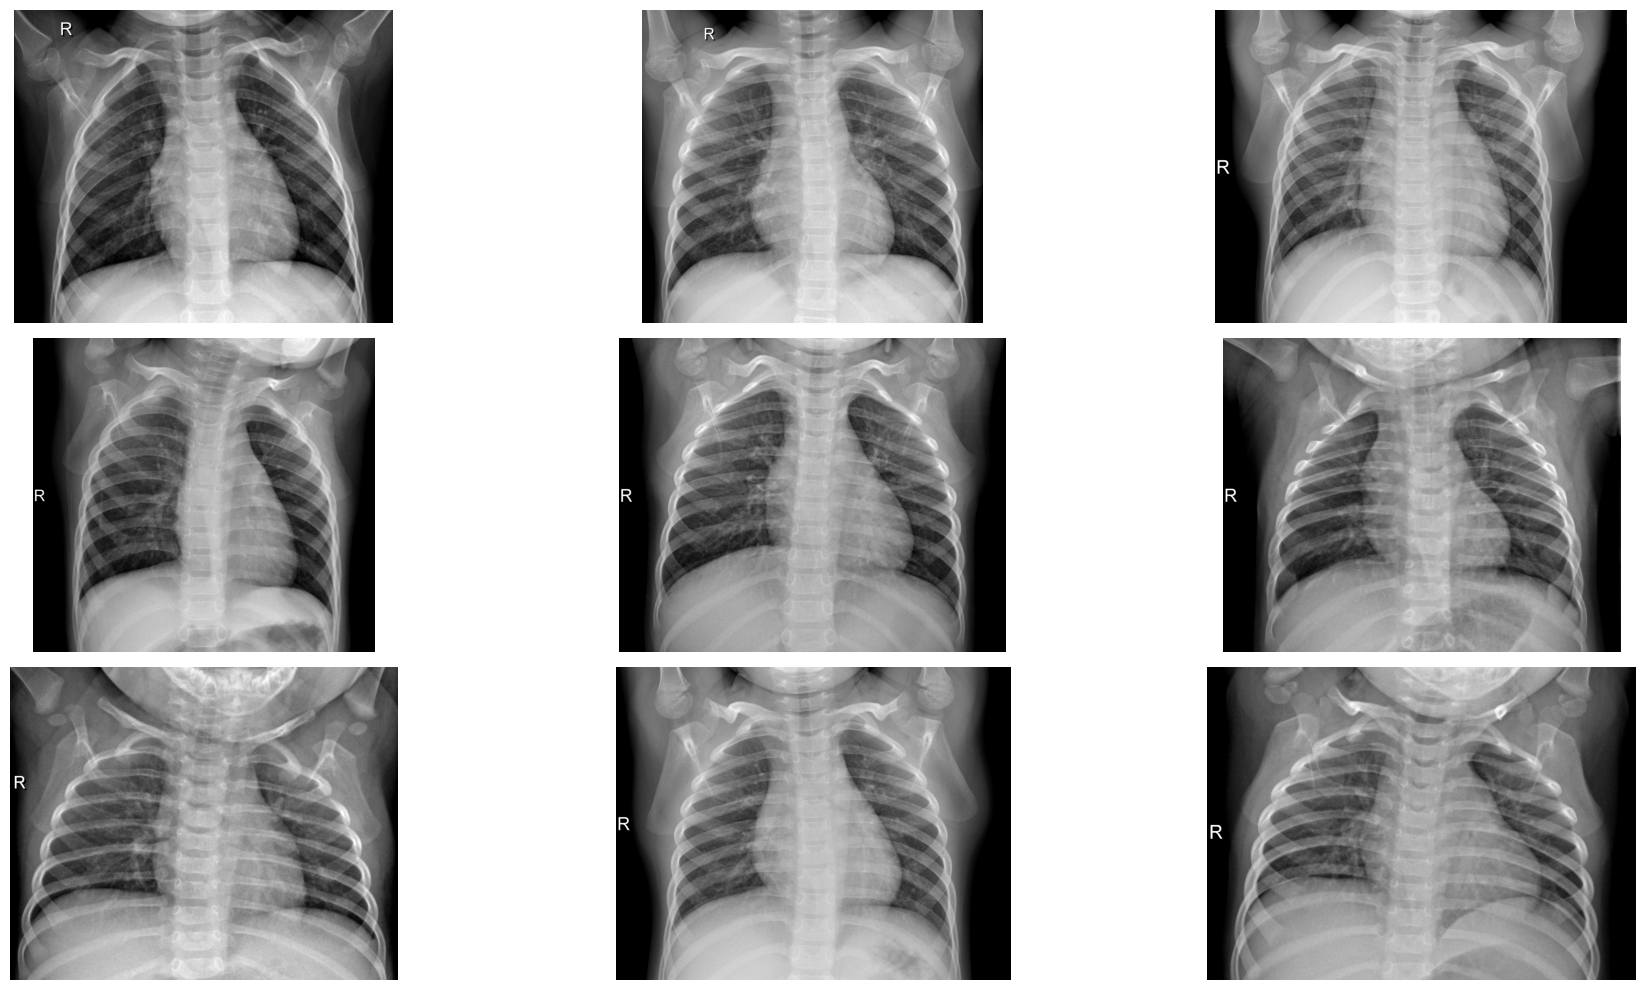

In [6]:
normal = os.listdir("chest_xray/chest_xray/train/NORMAL")
normal_dir = "chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

The dimensions of the image are 1340 pixels width and 1620 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 105.1570 and the standard deviation is 64.0073


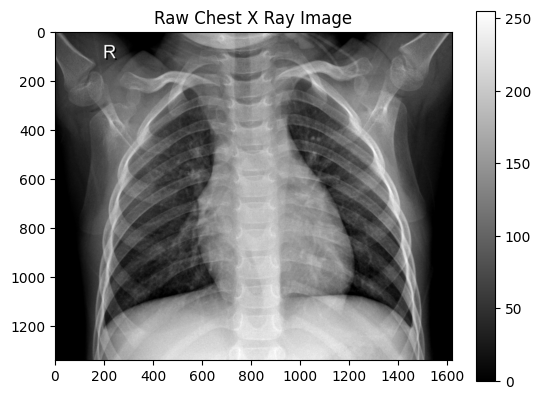

In [7]:
normal_img = os.listdir("chest_xray/chest_xray/train/NORMAL")[0]
normal_dir = "chest_xray/chest_xray/train/NORMAL"

sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")



<h3>Investigate pixel value distribution</h3>

/tmp/ipykernel_4762/296820011.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_img.ravel(),


Text(0, 0.5, '# Pixels in Image')

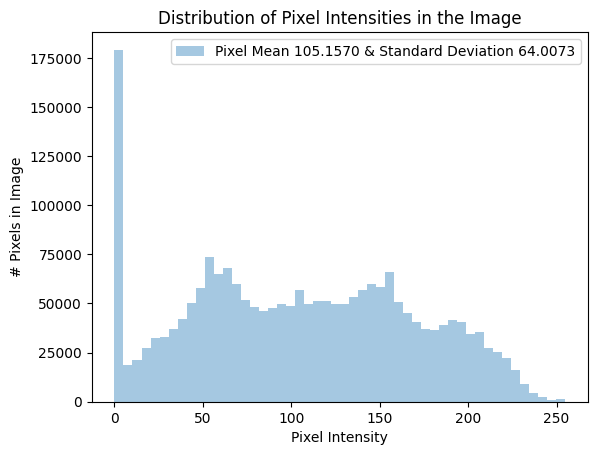

In [8]:
sns.distplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [9]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [10]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(320, 320))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(320, 320))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(320, 320))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height, one single color channel.
The maximum pixel value is 3.6268 and the minimum is -3.2247
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


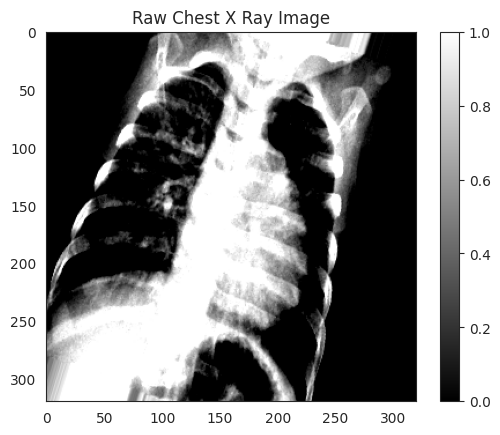

In [11]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

/tmp/ipykernel_4762/4033312467.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image.ravel(),


Text(0, 0.5, '# Pixels in Image')

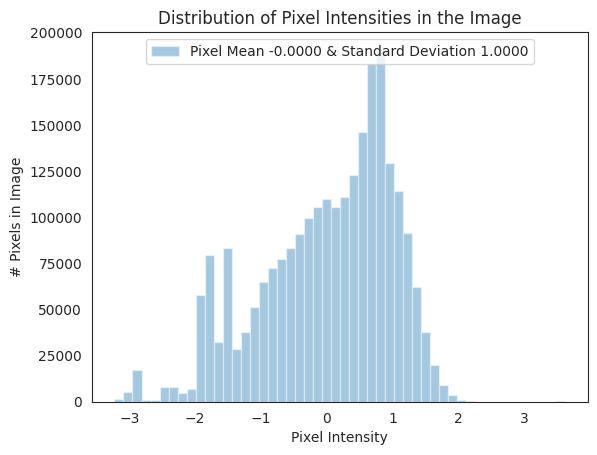

In [12]:
sns.distplot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", 
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [13]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [14]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

2024-04-04 19:21:30.095082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 19:21:30.095677: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 318, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 318, 318, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 316, 316, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 316, 316, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 158, 158, 32)     0         
 )                                                               
                                                        

In [16]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10


2024-04-04 19:22:05.109897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 2.5607 - accuracy: 0.8050

2024-04-04 19:25:33.075615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 209s 2s/step - loss: 2.5607 - accuracy: 0.8050 - val_loss: 29.2328 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 222s 2s/step - loss: 0.6868 - accuracy: 0.7937
Epoch 3/10
100/100 [==============================] - 223s 2s/step - loss: 0.2287 - accuracy: 0.7400
Epoch 4/10
100/100 [==============================] - 222s 2s/step - loss: 0.1649 - accuracy: 0.8550
Epoch 5/10
100/100 [==============================] - 228s 2s/step - loss: 0.1570 - accuracy: 0.8575
Epoch 6/10
100/100 [==============================] - 235s 2s/step - loss: 0.2138 - accuracy: 0.8462
Epoch 7/10
100/100 [==============================] - 238s 2s/step - loss: 0.1303 - accuracy: 0.8625
Epoch 8/10
100/100 [==============================] - 239s 2s/step - loss: 0.1241 - accuracy: 0.8950
Epoch 9/10
100/100 [==============================] - 242s 2s/step - loss: 0.1091 - accuracy: 0.8575
Epoch 10/10
100/100 [==============================] - 242s

Text(0.5, 1.0, 'Accuracy Evolution')

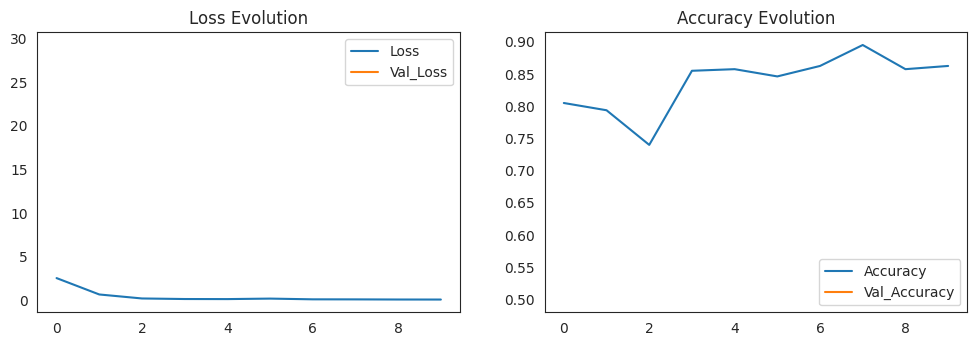

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [18]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

  2/624 [..............................] - ETA: 35s - loss: 0.2068 - accuracy: 1.0000 

2024-04-04 20:01:33.389506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


624/624 [==============================] - 37s 59ms/step - loss: 0.5247 - accuracy: 0.8317
Test Accuracy: 83.17%


2024-04-04 20:02:10.604213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


652/652 [==============================] - 337s 517ms/step - loss: 0.1849 - accuracy: 0.9239
Train Accuracy: 92.39%


In [19]:
pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

2024-04-04 20:11:35.053525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


624/624 [==============================] - 36s 58ms/step
[[150  84]
 [ 26 364]]


,0,1,accuracy,macro avg,weighted avg
precision,0.852273,0.812500,0.823718,0.832386,0.827415
recall,0.641026,0.933333,0.823718,0.787179,0.823718
f1-score,0.731707,0.868735,0.823718,0.800221,0.817350
support,234.000000,390.000000,0.823718,624.000000,624.000000


In [20]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[173  61]
 [ 42 348]]


,0,1,accuracy,macro avg,weighted avg
precision,0.804651,0.850856,0.834936,0.827753,0.833529
recall,0.739316,0.892308,0.834936,0.815812,0.834936
f1-score,0.770601,0.871089,0.834936,0.820845,0.833406
support,234.000000,390.000000,0.834936,624.000000,624.000000


<h3>DenseNet</h3>

In [21]:
base_model = DenseNet121(input_shape=(320, 320, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29084464/29084464 [==============================] - 6s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [22]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The model has 428 layers
The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [23]:
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10


2024-04-04 20:19:42.681073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.8087

2024-04-04 20:28:55.931146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 557s 5s/step - loss: 0.1729 - accuracy: 0.8087 - val_loss: 49.3408 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 581s 6s/step - loss: 0.1308 - accuracy: 0.8525
Epoch 3/10
100/100 [==============================] - 459s 5s/step - loss: 0.1144 - accuracy: 0.8813
Epoch 4/10
100/100 [==============================] - 461s 5s/step - loss: 0.1034 - accuracy: 0.8838
Epoch 5/10
100/100 [==============================] - 457s 5s/step - loss: 0.0889 - accuracy: 0.9025
Epoch 6/10
100/100 [==============================] - 451s 5s/step - loss: 0.0722 - accuracy: 0.9187
Epoch 7/10
100/100 [==============================] - 444s 4s/step - loss: 0.0991 - accuracy: 0.9038
Epoch 8/10
100/100 [==============================] - 446s 4s/step - loss: 0.0936 - accuracy: 0.8938
Epoch 9/10
100/100 [==============================] - 448s 4s/step - loss: 0.0891 - accuracy: 0.9087
Epoch 10/10
100/100 [==============================] - 448s

Text(0.5, 1.0, 'Accuracy Evolution')

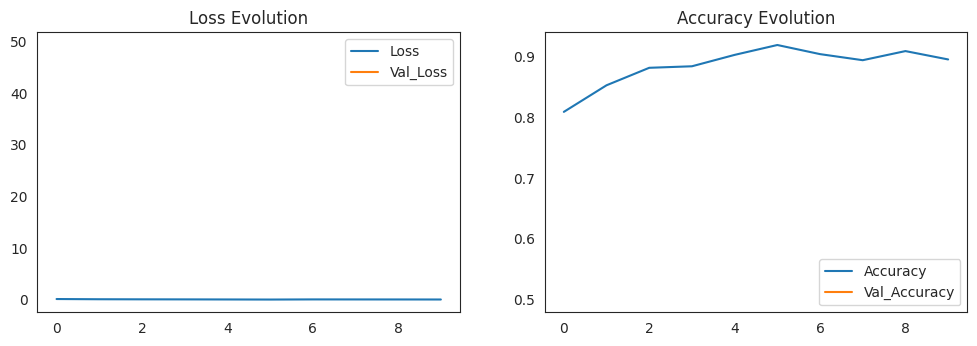

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [25]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

  1/624 [..............................] - ETA: 1:38 - loss: 4.8428e-04 - accuracy: 1.0000

2024-04-04 21:40:54.658542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


624/624 [==============================] - 63s 101ms/step - loss: 1.6155 - accuracy: 0.5272
Test Accuracy: 52.72%


2024-04-04 21:41:58.224881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


652/652 [==============================] - 516s 791ms/step - loss: 2.2775 - accuracy: 0.4062
Train Accuracy: 40.62%


In [26]:
predicted_vals = model.predict(test, steps=len(test))

2024-04-04 21:55:30.588636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


624/624 [==============================] - 65s 102ms/step


In [27]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

[[232   2]
 [290 100]]


,0,1,accuracy,macro avg,weighted avg
precision,0.444444,0.980392,0.532051,0.712418,0.779412
recall,0.991453,0.256410,0.532051,0.623932,0.532051
f1-score,0.613757,0.406504,0.532051,0.510130,0.484224
support,234.000000,390.000000,0.532051,624.000000,624.000000


In [28]:
print(confusion_matrix(test.classes, predicted_vals > 0.7))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.7, output_dict=True))

[[234   0]
 [318  72]]


,0,1,accuracy,macro avg,weighted avg
precision,0.423913,1.000000,0.490385,0.711957,0.783967
recall,1.000000,0.184615,0.490385,0.592308,0.490385
f1-score,0.595420,0.311688,0.490385,0.453554,0.418088
support,234.000000,390.000000,0.490385,624.000000,624.000000
